# Imports

In [1]:
import sys
import pandas as pd
import os
from tqdm import tqdm

from influxdb_client import InfluxDBClient, Point, WritePrecision
from influxdb_client.client.write_api import SYNCHRONOUS
from dotenv import dotenv_values
import warnings
from influxdb_client.client.warnings import MissingPivotFunction

warnings.simplefilter("ignore", MissingPivotFunction)

# Defines

In [2]:
token = dotenv_values("../../.env.local")['INFLUXDB_TOKEN']
org = "my-org"
bucket = "bucket-session-key"
url = "http://localhost:8086"

In [3]:
client = InfluxDBClient(url=url, token=token, org=org, timeout=60_000 * 2)
query_api = client.query_api()

# sql query

In [4]:
first_query = """
   SELECT 
        tlm.session_key, 
        tlm.driver_number,
        lap_duration,
        CASE 
            WHEN tlm.date > laps.date_start AND tlm.date < laps.date_start + INTERVAL '1 second' * laps.duration_sector_1 THEN 'SECTOR 1'
            WHEN tlm.date > (laps.date_start + INTERVAL '1 second' * laps.duration_sector_1) AND tlm.date < (laps.date_start + INTERVAL '1 second' * (laps.duration_sector_1 + laps.duration_sector_2)) THEN 'SECTOR 2'
            WHEN tlm.date > (laps.date_start + INTERVAL '1 second' * (laps.duration_sector_1 + laps.duration_sector_2)) AND (tlm.date <= laps.date_start + INTERVAL '1 second' * (laps.duration_sector_1 + laps.duration_sector_2 + laps.duration_sector_3)) THEN 'SECTOR 3'
        END AS sector,
        AVG(tlm.speed) AS max_speed
    FROM telemetrys tlm
    JOIN (
        SELECT
            driver_number,
            session_key,
            date_start,
            lap_duration,
            duration_sector_1,
            duration_sector_2,
            duration_sector_3
        FROM laps
        WHERE session_key in (
            SELECT session_key 
            FROM sessions
            WHERE session_name = 'Race'
        )
    ) laps
    ON tlm.session_key = laps.session_key AND tlm.driver_number = laps.driver_number AND tlm.date BETWEEN laps.date_start AND laps.date_start + (INTERVAL '1 second' * (laps.duration_sector_1 + laps.duration_sector_2 + laps.duration_sector_3))
    GROUP BY tlm.session_key, tlm.driver_number, sector, lap_duration
    HAVING lap_duration = MIN(lap_duration)
    ORDER BY tlm.session_key, tlm.driver_number, lap_duration, sector ASC
"""

# influx inicial

In [ ]:
query_laps = """
from(bucket: "bucket-session-key")
  |> range(start: 0)
  |> filter(fn: (r) => r._measurement == "laps" or r._measurement == "sessions")
  |> filter(fn: (r) => r.session_key == "9549" or r.session_key == "9693" or r.session_key == "9993" or r.session_key == "9998" or r.session_key == "10006" or r.session_key == "10022")
  |> filter(fn: (r) => 
      r._field == "duration_sector_1" or 
      r._field == "duration_sector_2" or 
      r._field == "duration_sector_3" or 
      r._field == "lap_duration"
  )
  |> pivot(
      rowKey: ["_time", "session_key", "driver_number"], 
      columnKey: ["_field"], 
      valueColumn: "_value"
  )
"""

# Leitura para executar a nova formatação
try:
    df_laps = query_api.query_data_frame(query=query_laps)
    if isinstance(df_laps, list):
        df_laps = pd.concat(df_laps, ignore_index=True)
except Exception as e:
    print(f"Erro ao executar a consulta: {e}")

In [ ]:

query_telemetries = """
from(bucket: "bucket-session-key")
    |> range(start: 0)
    |> filter(fn: (r) => r["_measurement"] == "telemetry")
    |> filter(fn: (r) => r["_field"] == "speed")
    |> filter(fn: (r) => r["session_key"] == "9549" or r["session_key"] == "9693" or r["session_key"] == "9993" or r["session_key"] == "9998" or r["session_key"] == "10006" or r["session_key"] == "10022")
    |> pivot(
        rowKey: ["_time", "session_key", "driver_number"], 
        columnKey: ["_field"], 
        valueColumn: "_value"
    )
"""

# Leitura para executar a nova formatação
try:
    df_telemetries = query_api.query_data_frame(query=query_telemetries)
    if isinstance(df_telemetries, list):
        df_telemetries = pd.concat(df_telemetries, ignore_index=True)
except Exception as e:
    print(f"Erro ao executar a consulta: {e}")

# Otimização

In [9]:
df_laps = df_laps.rename(columns={"_time": "date_start"})

In [10]:
df_laps = df_laps[["date_start", "driver_number", "session_key", "duration_sector_1", "duration_sector_2", "duration_sector_3"]].copy()
df_laps.loc[:, "date_start"] = pd.to_datetime(df_laps["date_start"])

df_laps.loc[:, "end_sector_1"] = df_laps["date_start"] + pd.to_timedelta(df_laps["duration_sector_1"], unit="s")
df_laps.loc[:, "end_sector_2"] = df_laps["end_sector_1"] + pd.to_timedelta(df_laps["duration_sector_2"], unit="s")
df_laps.loc[:, "end_sector_3"] = df_laps["end_sector_2"] + pd.to_timedelta(df_laps["duration_sector_3"], unit="s")

In [11]:
df_laps.head()

,date_start,driver_number,session_key,duration_sector_1,duration_sector_2,duration_sector_3,end_sector_1,end_sector_2,end_sector_3
0,2025-04-06 05:05:22.165000+00:00,1,10006,33.894,42.026,18.023,2025-04-06 05:05:56.059000+00:00,2025-04-06 05:06:38.085000+00:00,2025-04-06 05:06:56.108000+00:00
1,2025-04-06 05:06:56.025000+00:00,1,10006,33.567,42.027,18.045,2025-04-06 05:07:29.592000+00:00,2025-04-06 05:08:11.619000+00:00,2025-04-06 05:08:29.664000+00:00
2,2025-04-06 05:08:29.931000+00:00,1,10006,33.570,42.140,18.034,2025-04-06 05:09:03.501000+00:00,2025-04-06 05:09:45.641000+00:00,2025-04-06 05:10:03.675000+00:00
3,2025-04-06 05:13:11.027000+00:00,1,10006,33.193,42.278,18.055,2025-04-06 05:13:44.220000+00:00,2025-04-06 05:14:26.498000+00:00,2025-04-06 05:14:44.553000+00:00
4,2025-04-06 05:14:44.456000+00:00,1,10006,33.130,42.336,18.070,2025-04-06 05:15:17.586000+00:00,2025-04-06 05:15:59.922000+00:00,2025-04-06 05:16:17.992000+00:00


In [12]:
df_telemetries = df_telemetries.sample(frac=0.05, random_state=42)
df_telemetries = df_telemetries.rename(columns={"_time": "date"})
df_telemetries = df_telemetries[["driver_number", "session_key", "speed", "date"]].copy()

df_telemetries.loc[:, "date"] = pd.to_datetime(df_telemetries["date"])

In [13]:
df_join = pd.merge(
    df_telemetries,
    df_laps,
    on=["session_key", "driver_number"],
    how="left",
)

In [ ]:
def get_sector(row):
    if row['date_start'] <= row['date'] <= row['end_sector_1']:
        return 1
    elif row['end_sector_1'] < row['date'] <= row['end_sector_2']:
        return 2
    elif row['end_sector_2'] < row['date'] <= row['end_sector_3']:
        return 3
    else:
        return None

df_join['sector'] = df_join.apply(get_sector, axis=1).dropna(subset=['sector'])

In [17]:
df_join

,driver_number,session_key,speed,date,date_start,duration_sector_1,duration_sector_2,duration_sector_3,end_sector_1,end_sector_2,end_sector_3,sector
187,44,9998,272,2025-03-23 08:03:55.030000+00:00,2025-03-23 08:02:45.673000+00:00,25.937,29.605,46.909,2025-03-23 08:03:11.610000+00:00,2025-03-23 08:03:41.215000+00:00,2025-03-23 08:04:28.124000+00:00,3.0
226,63,10022,245,2025-04-20 18:02:24.919000+00:00,2025-04-20 18:02:02.340000+00:00,34.205,29.038,29.675,2025-04-20 18:02:36.545000+00:00,2025-04-20 18:03:05.583000+00:00,2025-04-20 18:03:35.258000+00:00,1.0
246,12,9998,307,2025-03-23 07:41:36.505000+00:00,2025-03-23 07:40:21.931000+00:00,26.045,29.638,42.099,2025-03-23 07:40:47.976000+00:00,2025-03-23 07:41:17.614000+00:00,2025-03-23 07:41:59.713000+00:00,3.0
346,44,10022,174,2025-04-20 17:09:27.709000+00:00,2025-04-20 17:08:51.769000+00:00,55.994,43.641,69.585,2025-04-20 17:09:47.763000+00:00,2025-04-20 17:10:31.404000+00:00,2025-04-20 17:11:40.989000+00:00,1.0
383,87,9998,294,2025-03-23 07:23:42.901000+00:00,2025-03-23 07:23:39.897000+00:00,26.610,30.160,42.388,2025-03-23 07:24:06.507000+00:00,2025-03-23 07:24:36.667000+00:00,2025-03-23 07:25:19.055000+00:00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3232722,31,9693,291,2025-03-16 04:43:47.951000+00:00,2025-03-16 04:43:46.154000+00:00,33.814,19.760,40.362,2025-03-16 04:44:19.968000+00:00,2025-03-16 04:44:39.728000+00:00,2025-03-16 04:45:20.090000+00:00,1.0
3232769,27,9998,235,2025-03-23 07:19:27.860000+00:00,2025-03-23 07:18:49.050000+00:00,26.611,30.482,42.622,2025-03-23 07:19:15.661000+00:00,2025-03-23 07:19:46.143000+00:00,2025-03-23 07:20:28.765000+00:00,2.0
3232836,30,9998,219,2025-03-23 08:23:20.473000+00:00,2025-03-23 08:22:59.574000+00:00,25.741,29.363,41.780,2025-03-23 08:23:25.315000+00:00,2025-03-23 08:23:54.678000+00:00,2025-03-23 08:24:36.458000+00:00,1.0
3232911,87,10022,295,2025-04-20 18:07:18.199000+00:00,2025-04-20 18:06:04.676000+00:00,34.837,29.663,29.727,2025-04-20 18:06:39.513000+00:00,2025-04-20 18:07:09.176000+00:00,2025-04-20 18:07:38.903000+00:00,3.0


In [26]:
write_api = client.write_api(write_options=SYNCHRONOUS)

for _, row in tqdm(df_join.iterrows(), total=len(df_join)):
    point = (
        Point("sectors2") 
        .tag("driver_number", str(row["driver_number"]))
        .tag("session_key", str(row["session_key"]))
        .tag("sector", str(row["sector"]))
        .field("speed", float(row["speed"]))
        .field("duration_sector_1", float(row["duration_sector_1"]))
        .field("duration_sector_2", float(row["duration_sector_2"]))
        .field("duration_sector_3", float(row["duration_sector_3"]))
        .time(row["date"], WritePrecision.NS)
    )
    write_api.write(bucket=bucket, org=org, record=point)

100%|██████████| 38831/38831 [05:30<00:00, 117.64it/s]


# Resultados

In [16]:
import numpy as np

def get_statistics(durations):
    """
    Calculate the mean and standard deviation of a list of durations.
    """
    mean = np.mean(durations)
    median = np.median(durations)
    std = np.std(durations)
    min_duration = np.min(durations)
    max_duration = np.max(durations)

    print(f"Mean: {mean:.6f} s")
    print(f"Median: {median:.6f} s")
    print(f"Std Dev: {std:.6f} s")
    print(f"Min: {min_duration:.6f} s")
    print(f"Max: {max_duration:.6f} s")

In [17]:
results_influx_dn = [
    388.82,
    389.24,
    391.22,
    390.24,
    391.94,
    391.71,
    390.21,
    389.83,
    392.89,
    391.72,
]

In [18]:
get_statistics(results_influx_dn)

Mean: 390.782000 s
Median: 390.730000 s
Std Dev: 1.243863 s
Min: 388.820000 s
Max: 392.890000 s


In [19]:
results_influx_sk = [
    47.6, 
    49.64, 
    48.79, 
    47.35, 
    50.3, 
    49.02, 
    48.46, 
    48.7, 
    48.2, 
    46.88
]

In [20]:
get_statistics(results_influx_sk)

Mean: 48.494000 s
Median: 48.580000 s
Std Dev: 0.989052 s
Min: 46.880000 s
Max: 50.300000 s


In [21]:
postgres = [
    0.123866,
    0.130727,
    0.130663,
    0.1138,
    0.111771,
    0.156512,
    0.124566,
    0.121826,
    0.119782,
    0.162265,
]

In [22]:
get_statistics(postgres)

Mean: 0.129578 s
Median: 0.124216 s
Std Dev: 0.016051 s
Min: 0.111771 s
Max: 0.162265 s


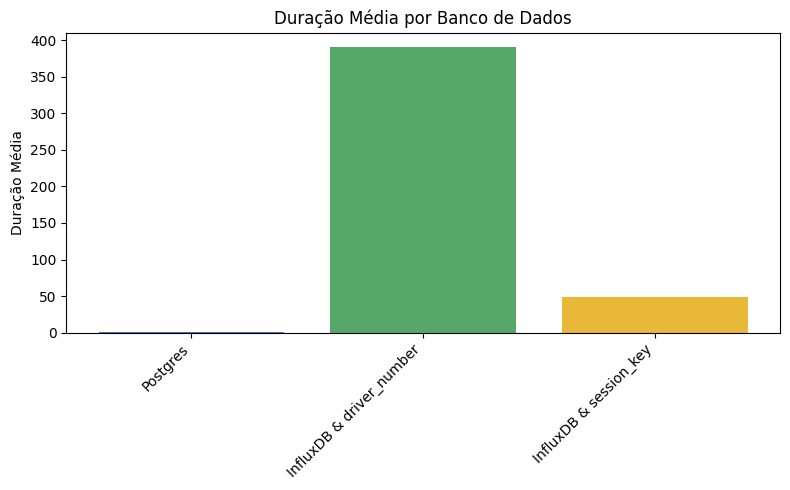

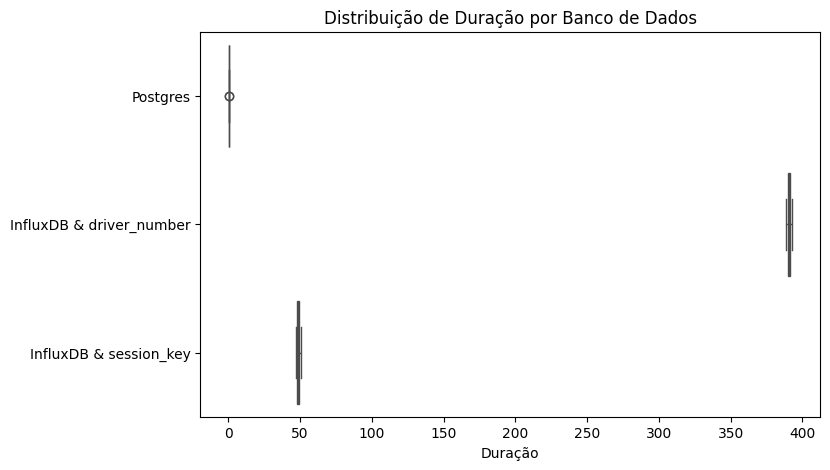

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

means = {
    "Postgres": sum(postgres) / len(postgres),
    "InfluxDB & driver_number": sum(results_influx_dn) / len(results_influx_dn),
    "InfluxDB & session_key": sum(results_influx_sk) / len(results_influx_sk),
}

# Gráfico de Barras (Médias)
plt.figure(figsize=(8, 5))
plt.bar(means.keys(), means.values(), color=['#4C72B0', '#55A868', '#EAB839'])
plt.title("Duração Média por Banco de Dados")
plt.ylabel("Duração Média")
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()

# Box Plot Horizontal
plt.figure(figsize=(8, 5))
sns.boxplot(data=[postgres, results_influx_dn, results_influx_sk], 
            palette=['#4C72B0', '#55A868', '#EAB839'], orient="h")
plt.yticks([0, 1, 2], ["Postgres", "InfluxDB & driver_number", "InfluxDB & session_key"])
plt.title("Distribuição de Duração por Banco de Dados")
plt.xlabel("Duração")
plt.show()